# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [2]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [9]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
12570,19037,63989,"North West, England",22-03-2020,People are being told only to go to the superm...,Positive
17684,25308,70260,NaN,25-03-2020,COVID 19 As you rush to stock food amp drive u...,Positive
29424,39919,84871,"Dallas, TX",09-04-2020,Watch out for coronavirus scams!\r\r\nEven in ...,Extremely Negative
3675,8260,53212,"Kampala, Uganda",18-03-2020,Order sanitizers online from They ve a great w...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [10]:
# Изучим возможные значения столбца Sentiment.
print(df["Sentiment"].unique())

# Преобразуем целевую переменную в бинарный вид.
df["Sentiment"] = df["Sentiment"].apply(lambda res: 1 if res == "Extremely Positive" or res == "Positive" else 0)
df.sample(4)

['Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
29792,40375,85327,NaN,09-04-2020,Cell Is this how you and keep yourselves profi...,1
27173,37118,82070,NaN,07-04-2020,prices eased from a 4 week high as and global ...,1
20608,28949,73901,United States,30-03-2020,PEOPLE stop #Hoarding! No shortage except mask...,0
7427,12820,57772,NaN,20-03-2020,Sorry to say but we as Muslims are the worst h...,0


Сбалансированы ли классы?

In [11]:
df["Sentiment"].value_counts() # Количество наблюдений.

Sentiment
1    18046
0    15398
Name: count, dtype: int64

In [12]:
round((df["Sentiment"].value_counts().max() - df["Sentiment"].value_counts().min()) / df["Sentiment"].value_counts().max() * 100) # Считаем искомую разницу в процентах.

15

**Ответ:** Разница в количестве наблюдений - 15% ⇒ классы сбалансированы.

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [13]:
print(df.isna().sum()) # В столбце Location присутствуют пропуски, заполним их строкой 'Unknown'.

df = df.fillna("Unknown")

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [15]:
words = " ".join(train["OriginalTweet"]).lower().split()
dictionary = {}

for w in words:
  dictionary[w] = dictionary.get(w, 0) + 1

Какой размер словаря получился?

In [16]:
len(dictionary)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [17]:
# Получаем 10 самых популярных токенов.
top10 = sorted(dictionary, key=dictionary.get, reverse=True)[:10]

for i in top10:
  print(i, ": ", dictionary[i], sep="")

the: 26815
to: 23373
and: 14684
of: 13012
a: 11737
in: 11198
for: 8566
#coronavirus: 8223
is: 7383
are: 7050


**Ответ:** 9 из 10 самых популярных токенов являются стоп-словами (встречаются практически в любом тексте и играют роль шума), поэтому они часто встречаются. Исключением среди популярных токенов является слово #coronavirus, его популярность обусловлена тем, что все твиты из датасета посвящены тематике коронавируса.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [18]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords", quiet=True)

# Удаляем стоп-слова.
for word in stopwords.words("english"):
  dictionary.pop(word, None)

# Получаем 10 самых популярных токенов.
top10 = sorted(dictionary, key=dictionary.get, reverse=True)[:10]

for i in top10:
  print(i, ": ", dictionary[i], sep="")

#coronavirus: 8223
prices: 3891
food: 3820
grocery: 3469
supermarket: 3288
people: 3175
covid-19: 3173
store: 3155
#covid19: 2471
&amp;: 2314


**Ответ:**  Новые популярные токены больше относятся к тематике ковида и к тому, что волновало людей в период пандемии. Исключением из этих слов является токен \&amp; который отвечает за символ амперсанда.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [19]:
# Получаем 20 самых непопулярных токенов.
bottom20 = sorted(dictionary, key=dictionary.get, reverse=False)[:20]

for i in bottom20:
  print(i, ": ", dictionary[i], sep="")

https://t.co/1m881cwfuv: 1
happy..: 1
https://t.co/z0intks34x: 1
mnuchinãâs: 1
brink.: 1
https://t.co/jmobv8z0u0: 1
university's: 1
teaching.): 1
@catholicpres: 1
@catholicuniv: 1
https://t.co/evqby035wf: 1
https://t.co/riqrhxxeim: 1
@@ballardspahrll: 1
#aca: 1
easier...take: 1
ãânecessaryãâ: 1
https://t.co/0fmsmlgepm: 1
husted:: 1
irishman: 1
#happystpatricksday!: 1


**Ответ:** К наименее популярным токенам помимо просто редких в упоминании слов и (или словосочетаний как easier...take) также относятся ссылки, упоминания и хештеги, не относящиеся к теме ковида и слова с символами юникода не из первой половины ascii-таблицы.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [20]:
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()
words = tw.tokenize(" ".join(train["OriginalTweet"]).lower())
dictionary = {}

for w in words:
  dictionary[w] = dictionary.get(w, 0) + 1

# Получаем 10 самых популярных токенов.
top10 = sorted(dictionary, key=dictionary.get, reverse=True)[:10]

for i in top10:
  print(i, ": ", dictionary[i], sep="")

the: 26993
.: 24108
to: 23478
,: 17571
and: 14825
of: 13044
a: 11891
in: 11348
?: 9524
#coronavirus: 8808


**Ответ:** В топ-10 самых популярных токенов появились знаки препинания, так как TweetTokenizer отделяет знаки препинания в самостоятельные токены.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [21]:
from string import punctuation

# Определяем шум (токены для удаления из словаря).
noise = stopwords.words("english") + list(punctuation)

# Удаляем стоп-слова и пунктуацию.
for word in noise:
  dictionary.pop(word, None)

# Получаем 10 самых популярных  токенов.
top10 = sorted(dictionary, key=dictionary.get, reverse=True)[:10]

for i in top10:
  print(i, ": ", dictionary[i], sep="")

#coronavirus: 8808
â: 7415
: 7311
19: 7167
covid: 6253
prices: 4601
: 4372
food: 4367
store: 3877
supermarket: 3805


**Ответ:** В токенах помимо привычных слов и тега есть односимвольные токены из символов юникода не из первой половины ascii-таблицы.

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [22]:
# Удаляем из словаря токены из одного символа, с позицией в таблице Unicode 128 и более.
keys = dictionary.copy().keys()
for key in keys:
  if (len(key) == 1 and ord(key[0]) >= 128):
    dictionary.pop(key, None)

In [23]:
# Получаем 10 самых популярных токенов.
top10 = sorted(dictionary, key=dictionary.get, reverse=True)[:10]

for i in top10:
  print(i, ": ", dictionary[i], sep="")

#coronavirus: 8808
19: 7167
covid: 6253
prices: 4601
food: 4367
store: 3877
supermarket: 3805
grocery: 3523
people: 3463
#covid19: 2589


In [24]:
# Получаем 20 самых непопулярных токенов.
bottom20 = sorted(dictionary, key=dictionary.get, reverse=False)[:20]

for i in bottom20:
  print(i, ": ", dictionary[i], sep="")

https://t.co/1m881cwfuv: 1
https://t.co/z0intks34x: 1
mnuchinã: 1
https://t.co/jmobv8z0u0: 1
university's: 1
@catholicpres: 1
@catholicuniv: 1
https://t.co/evqby035wf: 1
https://t.co/riqrhxxeim: 1
@ballardspahrll: 1
#aca: 1
https://t.co/0fmsmlgepm: 1
irishman: 1
#happystpatricksday: 1
guiness: 1
https://t.co/18v0pyhwb7: 1
https://t.co/ls0g86i8pu: 1
https://t.co/ofvkejff23: 1
https://t.co/xoodgd2ulx: 1
lifestyles: 1


**Ответ:** Что касается наиболее популярных токенов, то оба способа токенизации показывают хороший результат за исключением того, что TweetTokenizer разделил слово covid-19 по дефису на несколько токенов из-за чего теряется его смысл и говорит о лучшей работе первого способа токенизации. Структура наименее популярных токенов у обоих способов токенизации также схожа: ссылки, упоминания и теги, но из второго было произведено разделение по пункутации, что является его плюсом перед токенизацией по пробелу.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [25]:
# Берем все хештеги из словаря.
dict_hashtags = {}
for key in dictionary.keys():
  if ("#" in key):
    dict_hashtags[key] = dictionary[key]

# Получаем 10 самых популярных хештегов.
top10 = sorted(dict_hashtags, key=dictionary.get, reverse=True)[:10]

for i in top10:
  print(i, ": ", dictionary[i], sep="")

#coronavirus: 8808
#covid19: 2589
#covid_19: 1734
#covid2019: 946
#toiletpaper: 744
#covid: 641
#socialdistancing: 465
#coronacrisis: 448
#pandemic: 257
#coronaviruspandemic: 249


**Ответ:** Самые популярные хештеги напрямую относятся к тематике коронавируса.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [26]:
# Берем все ссылки из словаря.
dict_links = {}
for key in dictionary.keys():
  if ("https://t.co" in key):
    dict_links[key] = dictionary[key]

# Получаем 10 самых популярных ссылок.
top10 = sorted(dict_links, key=dictionary.get, reverse=True)[:10]

for i in top10:
  print(i, ": ", dictionary[i], sep="")

https://t.co/oxa7swtond: 5
https://t.co/gp3eusapl8: 4
https://t.co/deftrui1pfãâ: 3
https://t.co/wrlhyzizaa: 3
https://t.co/kuwipf1kqw: 3
https://t.co/zjnrx6dkkn: 3
https://t.co/3gbbdpdjat: 3
https://t.co/e2znxajpre: 3
https://t.co/catkegayoy: 3
https://t.co/g63rp042ho: 3


**Ответ:** # Ссылки гораздо менее популярны чем хештеги (популярность хештегов измеряется сотнями, а ссылок - единицами). Из этого можно сделать вывод, что токены, которые содержат ссылки, не имеют большого веса при принятии решения.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [27]:
def custom_tokenizer(text):
  tw = TweetTokenizer()
  words = tw.tokenize(text.lower())
  tokens = []

  # Определяем шум.
  noise = stopwords.words("english") + list(punctuation)

  # Удаляем шум, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки.
  for word in words:
    if (not ((len(word) == 1 and ord(word[0]) >= 128) or ("https://t.co" in word and word[0:12] == "https://t.co") or word in noise)):
      tokens.append(word)

  return tokens

In [28]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)

X = cv.fit_transform(train["OriginalTweet"])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** Размер словаря уменьшился почти в два раза (very ultra nice!).

Посмотрим на какой-нибудь конкретный твитт:

In [30]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [31]:
# Определяем самый важный и самый неважный токены.
tmp = list(enumerate(X[ind].toarray()[0]))
max_value = cv.get_feature_names_out()[max(tmp, key = lambda x: x[1])[0]]
min_value = cv.get_feature_names_out()[min(filter(lambda x: tmp[x[0]][1] != 0, tmp), key = lambda x: x[1])[0]]

print(max_value)
print(min_value)

#coronavirusoutbreak
#coronavirusoutbreak


**Ответ:** При использовании CountVectorizer плохо определились самый важный и самый неважный токены, так как он считает встречаемость только в конкретном твитте.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Применим TfidfVectorizer.
tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)

X = tfidf_vec.fit_transform(train["OriginalTweet"])

# Определяем самый важный и самый неважный токены.
tmp = list(enumerate(X[ind].toarray()[0]))
max_value = tfidf_vec.get_feature_names_out()[max(tmp, key = lambda x: x[1])[0]]
min_value = tfidf_vec.get_feature_names_out()[min(filter(lambda x: tmp[x[0]][1] != 0, tmp), key = lambda x: x[1])[0]]

print(max_value)
print(min_value)

brainless
food


**Ответ:** При использовании TfidfVectorizer получен более осмысленный результат для самого важного и самого неважного токенов, так как он считает важность конкретного слова для данного твитта (слово brainless имеет негативный смысловой оттенок, его выбор в качестве самого важного токена оправдано).

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [33]:
train[train['OriginalTweet'].apply(lambda x: ('awesome' in x)) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
663,4588,49540,954,17-03-2020,@HaileeSteinfeld IÃÂm good. Trying to keep m...,1
27905,38011,82963,"Bafoussam, Cameroon",08-04-2020,Get creative while in confinement This week we...,1
1640,5793,50745,Global,17-03-2020,A pianist in Barcelona went to his balcony dur...,1
28104,38260,83212,Unknown,08-04-2020,One of the top priorities Trump had when consi...,1
30507,41316,86268,Campbell River,10-04-2020,Let's be honest: #SocialDistancing sucks. Maki...,1
4139,8832,53784,Unknown,18-03-2020,@BoyersFood #COVID19 #WeAreInThisTogether \r\r...,1
17274,24818,69770,Unknown,25-03-2020,IF you can even FIND hand sanitizer the prices...,1
16392,23760,68712,"New Orleans, LA",24-03-2020,"Earlier this month, we completed Five Below in...",1
12783,19296,64248,"Essen, Germany",22-03-2020,its corona time Merch OUT NOW World wide shipp...,1
10890,17009,61961,"Wellington, FL, US, 33414",21-03-2020,Happy Saturday everyone!! We thought we'd ligh...,1


In [34]:
tmp_ind = 25767
tweet = train[train.index == tmp_ind]['OriginalTweet']
print(tweet.values[0])

# Находим индекс результата векторизации данного твитта.
tmp = list(enumerate(train.index))
ind = list(filter(lambda x: x[1] == tmp_ind, tmp))[0][0]

# Определяем самый важный токен.
tmp = list(enumerate(X[ind].toarray()[0]))
max_value = tfidf_vec.get_feature_names_out()[max(tmp, key = lambda x: x[1])[0]]

print("\nImportant token:")
print(max_value)

So awesome to see how big business is coming together to contribute to the solution to beat #coronavirus #Ikea is making masks and sanitizer to help fight COVID-19 https://t.co/H8JJRnNb4X @IKEAUSA #coronavirus #Masks4All #Masks #MasksSaveLives https://t.co/yzPyfFXvP6

Important token:
#maskssavelives


**Ответ:** В твитте по индексу 25767 пишется о том, что крупные компании объединяются для борьбы с коронавирусом. TfidfVectorizer выделил хештег #maskssavelives как самый важный токен для определения окраса твитта, с чем можно согласиться: этот тег имеет большой вес для данного твита (он не входит в 10 самых популярных тегов из словаря) и несёт положительный смысловой оттенок.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [35]:
cnt_vec = CountVectorizer(tokenizer=custom_tokenizer)
tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)

X_train_cnt_vec = cnt_vec.fit_transform(train["OriginalTweet"])
X_train_tfidf_vec = tfidf_vec.fit_transform(train["OriginalTweet"])

X_test_cnt_vec = cnt_vec.transform(test["OriginalTweet"])
X_test_tfidf_vec = tfidf_vec.transform(test["OriginalTweet"])

y_train = train['Sentiment']
y_test = test['Sentiment']

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# CountVectorizer.
# Обучаем логистическую регрессию.
clf_cnt_vec = LogisticRegression(max_iter=200, random_state=42)
clf_cnt_vec.fit(X_train_cnt_vec, y_train)

# Изучаем accuracy предсказания.
print('Logistic regression, CountVectorizer:')
print(f'Accuracy on train = {accuracy_score(y_train, clf_cnt_vec.predict(X_train_cnt_vec))}')
print(f'Accuracy on test = {accuracy_score(y_test, clf_cnt_vec.predict(X_test_cnt_vec))}')

# TfidfVectorizer.
# Обучаем логистическую регрессию.
clf_tfidf_vec = LogisticRegression(max_iter=200, random_state=42)
clf_tfidf_vec.fit(X_train_tfidf_vec, y_train)

# Изучаем accuracy предсказания.
print('\nLogistic regression, TfidfVectorizer:')
print(f'Accuracy on train = {accuracy_score(y_train, clf_tfidf_vec.predict(X_train_tfidf_vec))}')
print(f'Accuracy on test = {accuracy_score(y_test, clf_tfidf_vec.predict(X_test_tfidf_vec))}')

Logistic regression, CountVectorizer:
Accuracy on train = 0.9844510892780863
Accuracy on test = 0.8672513454255532

Logistic regression, TfidfVectorizer:
Accuracy on train = 0.9254592054677488
Accuracy on test = 0.8533984452860275


**Ответ:** Обе модели выдают примерно одинаковую доль правильных ответов на обучающей и тестовой выборках: accuracy у CountVectorizer на тестовой выборке - 86,7%, что на 1,4% лучше, чем у TfidfVectorizer, а на обучающей - 98,4%, что на 5,9% лучше, чем у TfidfVectorizer. Результаты на тестовых выборках у обеих моделей > 85% ⇒ ultra very nice модели!

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [37]:
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
  tmp_tokens = custom_tokenizer(text)

  stemmer = SnowballStemmer("english")
  tokens = [stemmer.stem(w) for w in tmp_tokens]

  return tokens

In [38]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [39]:
cnt_vec = CountVectorizer(tokenizer=custom_stem_tokenizer)
tfidf_vec = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

X_train_cnt_vec = cnt_vec.fit_transform(train["OriginalTweet"])
X_train_tfidf_vec = tfidf_vec.fit_transform(train["OriginalTweet"])

X_test_cnt_vec = cnt_vec.transform(test["OriginalTweet"])
X_test_tfidf_vec = tfidf_vec.transform(test["OriginalTweet"])

y_train = train['Sentiment']
y_test = test['Sentiment']

print(len(cnt_vec.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


**Ответ:** Размер словаря уменьшился на 8656 (≈20%), это хороший результат.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [40]:
# CountVectorizer.
# Обучаем логистическую регрессию.
clf_cnt_vec = LogisticRegression(max_iter=200, random_state=42)
clf_cnt_vec.fit(X_train_cnt_vec, y_train)

# Изучаем accuracy предсказания.
print('Logistic regression, CountVectorizer:')
print(f'Accuracy on train = {accuracy_score(y_train, clf_cnt_vec.predict(X_train_cnt_vec))}')
print(f'Accuracy on test = {accuracy_score(y_test, clf_cnt_vec.predict(X_test_cnt_vec))}')

# TfidfVectorizer.
# Обучаем логистическую регрессию.
clf_tfidf_vec = LogisticRegression(max_iter=200, random_state=42)
clf_tfidf_vec.fit(X_train_tfidf_vec, y_train)

# Изучаем accuracy предсказания.
print('\nLogistic regression, TfidfVectorizer:')
print(f'Accuracy on train = {accuracy_score(y_train, clf_tfidf_vec.predict(X_train_tfidf_vec))}')
print(f'Accuracy on test = {accuracy_score(y_test, clf_tfidf_vec.predict(X_test_tfidf_vec))}')

Logistic regression, CountVectorizer:
Accuracy on train = 0.9718923536950022
Accuracy on test = 0.8672513454255532

Logistic regression, TfidfVectorizer:
Accuracy on train = 0.9158906450234943
Accuracy on test = 0.8560892963922663


**Ответ:** Обе модели потеряли 1% в доле правильных ответов на обучающей выборке при применении стемминга, но на тестовой выборке accuracy у CountVectorizer не изменился, а у TfidfVectorizer - вырос на 0,3%. Благодаря стеммингу мы уменьшили словарь и не приобрели значительного преимущества в улучшении качества моделей ⇒ применять стемминг не имеет особого смысла.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [41]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=8000).fit(train["OriginalTweet"])
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


**Ответ:** подобранный max_df отсеивает токен, если он присутсвует больше, чем в 8000 текстов из 33444 (≈25%). Такое большое значение параметра обусловлено тем, что по умолчанию берутся все слова, а нам необходимо отсеить ровно одно из них (при меньших значениях параметра мы рискуем отсеить слишком много слов, которые имеют большой вес для отдельных твиттов).

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [42]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11).fit(train["OriginalTweet"])
print(len(cv_df.vocabulary_))

3700


**Ответ:** подобранный min_df отсеивает токен, если он присутсвует меньше, чем в 11 текстах из 33444 (≈0,0003%). Такое маленькое значение параметра обусловлено тем, что при его даже небольшом увеличении мы исключаем много слов, которые имеют большой вес для отдельных твиттов.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [43]:
from sklearn.preprocessing import StandardScaler

y_train = train['Sentiment']
y_test = test['Sentiment']

cnt_vec_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11)

X_train_cnt_vec_df = cnt_vec_df.fit_transform(train["OriginalTweet"])
X_test_cnt_vec_df = cnt_vec_df.transform(test["OriginalTweet"])

# Скалируем данные.
scaler = StandardScaler(with_mean=False)
X_train_cnt_vec_df = scaler.fit_transform(X_train_cnt_vec_df)
X_test_cnt_vec_df = scaler.transform(X_test_cnt_vec_df)

# CountVectorizer.
# Обучаем логистическую регрессию.
clf_cnt_vec_df = LogisticRegression(max_iter=200, random_state=42)
clf_cnt_vec_df.fit(X_train_cnt_vec_df, y_train)

# Изучаем accuracy предсказания.
print('Logistic regression, CountVectorizer + Scaler:')
print(f'Accuracy on train = {accuracy_score(y_train, clf_cnt_vec_df.predict(X_train_cnt_vec_df))}')
print(f'Accuracy on test = {accuracy_score(y_test, clf_cnt_vec_df.predict(X_test_cnt_vec_df))}')

Logistic regression, CountVectorizer + Scaler:
Accuracy on train = 0.9416915847928236
Accuracy on test = 0.8446282639027307


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Axes: >

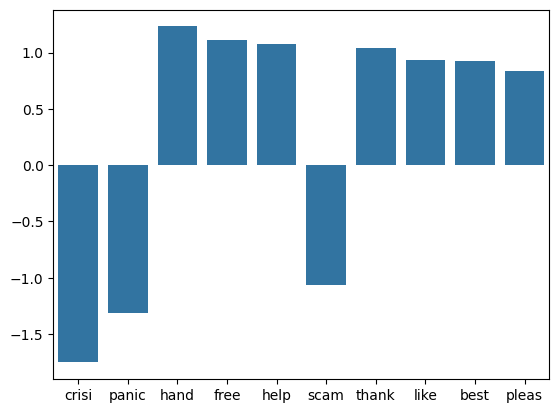

In [44]:
tmp = list(enumerate(clf_cnt_vec_df.coef_[0]))

# Получаем 10 наибольших по модулю весов.
top10_weights = sorted(tmp, key=lambda x: abs(x[1]), reverse=True)[:10]

# Определяем по ним искомые токены.
top10_tokens = cnt_vec_df.get_feature_names_out()[list(x[0] for x in top10_weights)]

sns.barplot(x=top10_tokens, y=list(x[1] for x in top10_weights))

**Ответ:** Доля правильных ответов упала на 4% на обучающей и на 2% на тестовой выборках. Токены с большими отрицательными весами несут резко негативный смысловой оттенок (panic, scam...), в то время как токены с большими положительными весами имеют позитивное значение (help, pleas, best...).

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [47]:
print("Total:", train.shape[0])
print("UserName:", train["UserName"].nunique())
print("ScreenName:", train["ScreenName"].nunique())

Total: 23410
UserName: 23410
ScreenName: 23410


**Ответ:** Число уникальных значений в признаках UserName и ScreenName в train совпадает с размером обучающей выборки, т.е. каждому пользователю соответствует только один твитт ⇒ эти признаки не будут полезны для обучения: если значение этих признаков на тестовой выборке совпадет со значением какого-то объекта, на котором проходило обучение модели, то оно в общем случае не будет сильно влиять на конечный результат.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

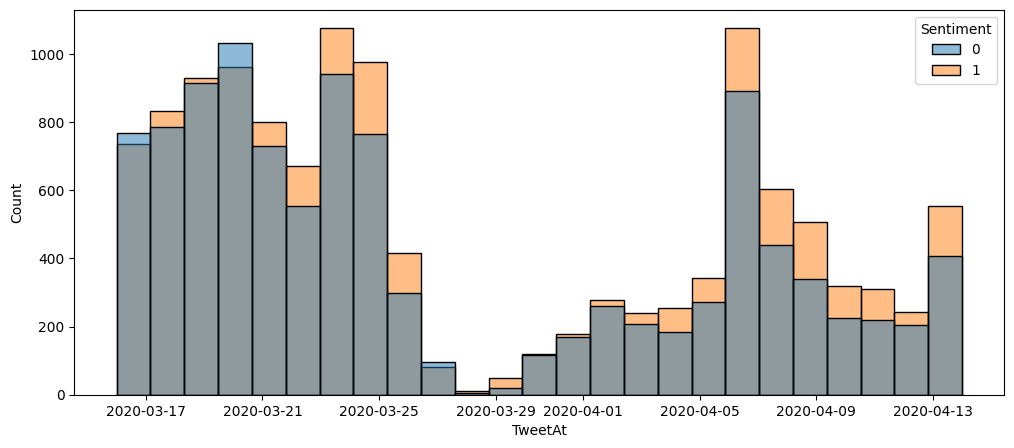

In [48]:
train['TweetAt'] = pd.to_datetime(df['TweetAt'], dayfirst=True)

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=train, x="TweetAt", hue="Sentiment", ax=ax)
plt.show()

**Ответ:** Исходя из построенной гистограммы при делении по признаку TweetAt каждому промежутку времени соответсвует примерно одинаковое число объектов из обоих целевых классов ⇒ признак TweetAt не будет иметь большого влияния на определения целевого значения.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [49]:
print("Location:", train["Location"].nunique())

Location: 7949


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

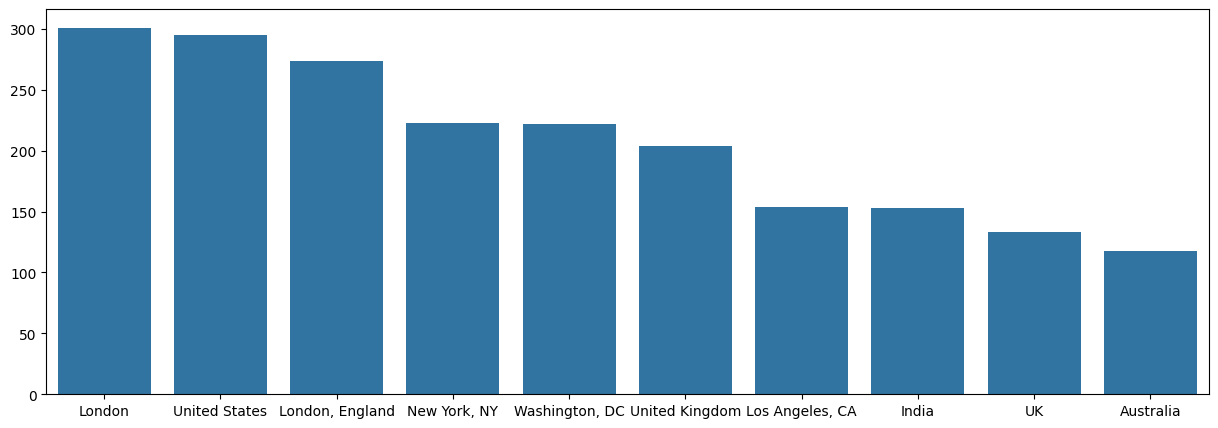

In [50]:
dictionary = {}
tmp = list(train[train["Location"] != "Unknown"]["Location"])

for w in tmp:
  dictionary[w] = dictionary.get(w, 0) + 1

# Получаем 10 самых популярных местоположений.
top10_locations = sorted(dictionary, key=dictionary.get, reverse=True)[:10]

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x=top10_locations, y=[dictionary[x] for x in top10_locations], ax=ax)
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

WiderLocation: 5163


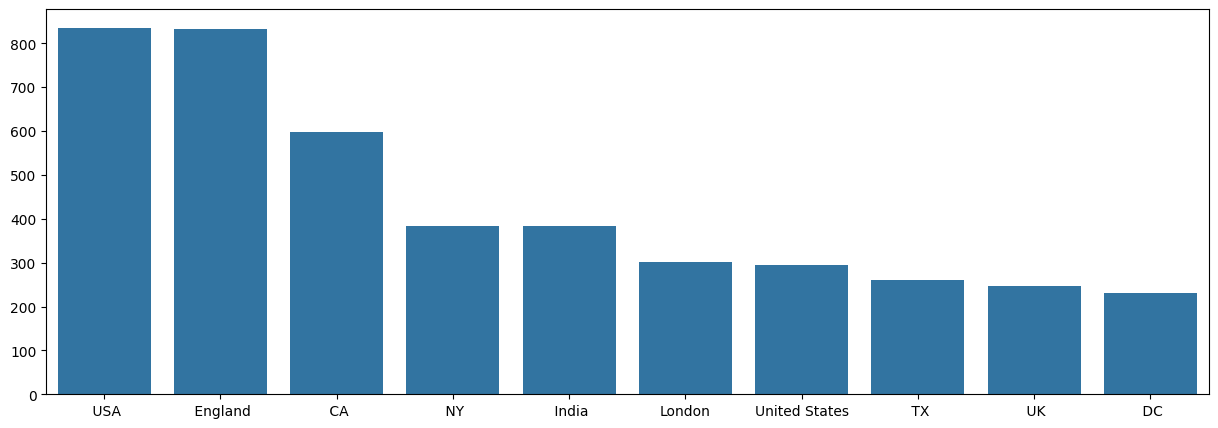

In [55]:
import re

# Вспомогательная функция.
def fun(x):
  if "," in x:
    return re.split(',|, ', x)[-1]
  return x

train['WiderLocation'] = train['Location'].map(fun)

# Число уникальных значений.
print("WiderLocation:", train["WiderLocation"].nunique())

dictionary = {}
tmp = list(train[train["WiderLocation"] != "Unknown"]["WiderLocation"])

for w in tmp:
  dictionary[w] = dictionary.get(w, 0) + 1

# Получаем 10 самых популярных общих местоположений.
top10_widerLocations = sorted(dictionary, key=dictionary.get, reverse=True)[:10]

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x=top10_widerLocations, y=[dictionary[x] for x in top10_widerLocations], ax=ax)
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [204]:
from sklearn.preprocessing import OneHotEncoder

i = train["WiderLocation"].unique()
tmp = np.select([train["WiderLocation"].value_counts()[i] > 1], [i])
tmp = list(tmp[tmp != 0])

# Число закодированных значений.
print("Encoded WiderLocation:", len(tmp))

# Танцы с бубнами для OHE.
encoder = OneHotEncoder(categories=[tmp], handle_unknown ='ignore')
df_oe = train.copy()
df_oe = encoder.fit_transform(df_oe['WiderLocation'].to_numpy().reshape(-1, 1))

tmp2 = train.reset_index()
ohe_df = pd.DataFrame(df_oe.toarray(), columns=encoder.get_feature_names_out())

train_ohe = pd.concat([tmp2, ohe_df], axis=1).set_index('index').drop(['WiderLocation'], axis=1)

train_ohe.head(5)

Encoded WiderLocation: 1159


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,x0_Unknown,x0_India,x0_ UK,x0_ MD,...,x0_ Australia.,x0_Libya,x0_Nanning,x0_#WeAreThePatriots,x0_ Mercury & Jupiter,x0_Brighton & Hove,x0_Home,x0_U.S.A,x0_Republic of Korea,x0_IMAGINATION
index,,,,,,,,,,,,,,,,,,,,,
25621,35178,80130,Unknown,2020-04-06,Why we still want to buy so much stuff during ...,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30135,40819,85771,"Boston, MA HQ",2020-04-10,With driving even more usage a strong strategy...,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28899,39249,84201,India,2020-04-09,@Canon_India I am very happy.. Great job by @C...,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5989,11068,56020,"Mayfair, London, UK",2020-03-19,The U.S national debt will likely exceed $30 T...,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4367,9109,54061,WNC,2020-03-18,"Finally got to the grocery store. Honestly, wh...",1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [205]:
# Склеиваем матрицы признаков в тренировочной выборке.
array1 = X_train_cnt_vec_df.toarray()
array2 = train_ohe[train_ohe.columns[6:]].to_numpy()
X_train_cnt_vec_df_loc = np.concatenate((array1, array2), axis=1)

# CountVectorizer.
# Обучаем логистическую регрессию.
clf_cnt_vec_df = LogisticRegression(max_iter=200, random_state=42)
clf_cnt_vec_df.fit(X_train_cnt_vec_df_loc, y_train)

# OHE для тестовой выборки.
test['WiderLocation'] = test['Location'].map(fun)
df_oe = test.copy()
df_oe = encoder.transform(df_oe['WiderLocation'].to_numpy().reshape(-1, 1))
df_oe = pd.DataFrame(df_oe.toarray(), columns=encoder.get_feature_names_out())

array1 = X_test_cnt_vec_df.toarray()
array2 = df_oe.to_numpy()
X_test_cnt_vec_df_loc = np.concatenate((array1, array2), axis=1)

# Изучаем accuracy предсказания.
print('Logistic regression, CountVectorizer + Scaler:')
print(f'Accuracy on train = {accuracy_score(y_train, clf_cnt_vec_df.predict(X_train_cnt_vec_df_loc))}')
print(f'Accuracy on test = {accuracy_score(y_test, clf_cnt_vec_df.predict(X_test_cnt_vec_df_loc))}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression, CountVectorizer + Scaler:
Accuracy on train = 0.9461341307133704
Accuracy on test = 0.844229619294399


**Ответ:** Доля правильных ответов на обучающей выборке увеличилась на 0,5%, а на тестовой - уменьшилась на 0,4% по сравнению с просто отскалированными признаками. Показатели все еще хуже, чем при векторизации без шаманских фокусов ⇒ использовать признак местоположения не имеет особого смысла для улучшения модели.

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
# Not today...